In [1]:
import os, sys, math, json, random, time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa, soundfile as sf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Project paths
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
CACHE_DIR = PROJECT_ROOT / "outputs" / "cache_cnn"
ARTIFACTS_DIR = PROJECT_ROOT / "outputs" / "artifacts"
for p in [CACHE_DIR, ARTIFACTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Experiment config
MACHINE = "fan"         # fan, pump, slider, valve, toycar, toyconveyor
TARGET_FPR = 0.10       # target false positive rate for NP threshold

# Audio + features
SR = 16000
N_FFT = 1024
HOP = 512
N_MELS = 128

# Patch slicing for CNN input (M x T window)
PATCH_T = 64            # time frames per patch
PATCH_STRIDE = 32       # hop in frames between patches

# Training
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50
VAL_SPLIT = 0.1
PATIENCE = 8

# Optional labels CSV
LABELS_CSV = None  # CSV with columns [path,label] where label in {0,1}; leave None to skip AUC

Device: cuda


In [3]:
def list_wavs(machine: str):
    """
    Return two lists of wav Paths for the given machine.
    train contains only normal sounds.
    test contains a mix of normal and anomalies.
    """
    train = sorted((DATA_DIR / machine / "train").glob("*.wav"))
    test  = sorted((DATA_DIR / machine / "test").glob("*.wav"))
    return train, test

train_paths, test_paths = list_wavs(MACHINE)
print(f"Machine: {MACHINE}")
print(f"Train files: {len(train_paths)}")
print(f"Test files:  {len(test_paths)}")
print("Example train file:", train_paths[0].name if train_paths else "N/A")
print("Example test file: ", test_paths[0].name if test_paths else "N/A")

assert len(train_paths) > 0 and len(test_paths) > 0, "Missing audio. Check data paths."

Machine: fan
Train files: 3675
Test files:  1875
Example train file: normal_id_00_00000000.wav
Example test file:  anomaly_id_00_00000000.wav


In [4]:
def wav_to_logmel(path: Path, sr=SR, n_fft=N_FFT, hop=HOP, n_mels=N_MELS) -> np.ndarray:
    """
    Load mono audio. Compute log-Mel spectrogram in dB.
    Returns [n_mels, T] float32.
    """
    y, sr0 = librosa.load(path, sr=None, mono=True)
    if sr0 != sr:
        y = librosa.resample(y, orig_sr=sr0, target_sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.astype(np.float32)

def extract_patches(mel_db: np.ndarray, win_t=PATCH_T, stride=PATCH_STRIDE) -> np.ndarray:
    """
    Slice [M, T] into overlapping patches shaped [1, M, win_t].
    Pad on the right if the clip is shorter than the window.
    Returns array [N, 1, M, win_t].
    """
    M, T = mel_db.shape
    if T < win_t:
        pad = np.tile(mel_db[:, -1:], (1, win_t - T))
        mel_db = np.concatenate([mel_db, pad], axis=1)
        T = mel_db.shape[1]
    patches = []
    for start in range(0, T - win_t + 1, stride):
        patch = mel_db[:, start:start+win_t]
        patches.append(patch[None, :, :])  # add channel dim
    return np.stack(patches, axis=0).astype(np.float32)

def cache_mel_if_needed(path: Path) -> Path:
    """
    Save Mel spectrogram to cache as .npy if not cached yet.
    Returns path to the .npy file.
    """
    out = CACHE_DIR / f"{path.stem}_mel.npy"
    if not out.exists():
        mel = wav_to_logmel(path)
        np.save(out, mel)
    return out

# Run a tiny preview on 1 file to confirm preprocessing
_preview_cache = cache_mel_if_needed(train_paths[0])
_preview_mel = np.load(_preview_cache)
print("Preview Mel:", _preview_mel.shape)  # should be [n_mels, T]
print("One file patched shape:", extract_patches(_preview_mel).shape)  # [N,1,M,T]

Preview Mel: (128, 313)
One file patched shape: (8, 1, 128, 64)


In [5]:
class CNNPatchesDataset(Dataset):
    """
    Dataset that yields 2D log-Mel patches for a CNN autoencoder.

    Train:
      - uses normal train files only
      - computes mean/std on a subset of train patches for normalization

    Test:
      - uses test files for scoring
      - uses training mean/std passed via set_norm(mean, std)
    """
    def __init__(self, paths, train=True):
        self.paths = list(paths)
        self.train = train
        self.index = []              # list of (file_idx, patch_idx)
        self.file_patch_counts = []  # number of patches per file (for aggregation)

        # Build index and cache Mel
        for fi, p in enumerate(tqdm(self.paths, desc="Precompute patches")):
            mel_path = cache_mel_if_needed(p)
            mel = np.load(mel_path)
            patches = extract_patches(mel)
            self.file_patch_counts.append(len(patches))
            for pi in range(len(patches)):
                self.index.append((fi, pi))

        # Compute normalization stats on train subset
        if self.train:
            sample_idxs = np.random.choice(len(self.index), min(8000, len(self.index)), replace=False)
            sample_patches = []
            for idx in sample_idxs:
                fi, pi = self.index[idx]
                mel = np.load(CACHE_DIR / f"{self.paths[fi].stem}_mel.npy")
                patch = extract_patches(mel)[pi]  # [1,M,T]
                sample_patches.append(patch)
            X = np.concatenate(sample_patches, axis=0)  # [N,1,M,T]
            self.mean = X.mean()
            self.std = X.std() + 1e-6
        else:
            self.mean = None
            self.std = None

    def set_norm(self, mean: float, std: float):
        """Set normalization stats from the training dataset."""
        self.mean = float(mean)
        self.std = float(std)

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, pi = self.index[idx]
        mel = np.load(CACHE_DIR / f"{self.paths[fi].stem}_mel.npy")
        patch = extract_patches(mel)[pi]  # [1,M,T]
        patch = (patch - self.mean) / self.std if self.mean is not None else patch
        # target is the same as input for an autoencoder
        return torch.from_numpy(patch), torch.from_numpy(patch)

# Build datasets
ds_train_full = CNNPatchesDataset(train_paths, train=True)

# Split normal train into train/val
val_len = max(1, int(len(ds_train_full) * VAL_SPLIT))
train_len = len(ds_train_full) - val_len
ds_train, ds_val = random_split(ds_train_full, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))

# Build test
ds_test = CNNPatchesDataset(test_paths, train=False)
ds_test.set_norm(ds_train_full.mean, ds_train_full.std)

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train patches:", len(ds_train))
print("Val patches:  ", len(ds_val))
print("Test patches: ", len(ds_test))

Precompute patches: 100%|██████████| 1875/1875 [00:00<00:00, 3372.61it/s]

Train patches: 26460
Val patches:   2940
Test patches:  15000


In [6]:
class CNNAutoencoder(nn.Module):
    """
    Small 2D CNN autoencoder for log-Mel patches.
    Input:  [B, 1, M=128, T=PATCH_T]
    Output: [B, 1, M=128, T=PATCH_T]
    """
    def __init__(self, in_ch=1):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)),  # [64, T/2]
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d((2,2)),  # [32, T/4]
        )
        # Decoder (mirror)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),  # [64, T/2]
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), nn.ReLU(),  # [128, T]
            nn.Conv2d(16, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        return y

model = CNNAutoencoder(in_ch=1).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

print("Model params:", sum(p.numel() for p in model.parameters()))

Model params: 33729


In [7]:
def train_epoch(model, loader, opt, loss_fn):
    """
    One training epoch. Returns average loss.
    """
    model.train()
    total = 0.0
    for x, y in loader:
        x = x.to(DEVICE, dtype=torch.float32)
        y = y.to(DEVICE, dtype=torch.float32)
        opt.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        opt.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

def eval_epoch(model, loader, loss_fn):
    """
    One validation epoch. Returns average loss.
    """
    model.eval()
    total = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE, dtype=torch.float32)
            y = y.to(DEVICE, dtype=torch.float32)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            total += loss.item() * x.size(0)
    return total / len(loader.dataset)

best_val = math.inf
patience_ctr = 0
best_state = None

for epoch in range(1, EPOCHS+1):
    tr = train_epoch(model, dl_train, opt, loss_fn)
    va = eval_epoch(model, dl_val, loss_fn)
    print(f"[{epoch:03d}] train={tr:.6f}  val={va:.6f}")

    if va < best_val - 1e-6:
        best_val = va
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        patience_ctr = 0
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping.")
            break

# Load best weights
if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

[001] train=0.111772  val=0.076768
[002] train=0.070187  val=0.063370
[003] train=0.056562  val=0.052746
[004] train=0.050230  val=0.049260
[005] train=0.047016  val=0.045533
[006] train=0.044888  val=0.044097
[007] train=0.043296  val=0.043281
[008] train=0.042083  val=0.041757
[009] train=0.041106  val=0.040199
[010] train=0.040210  val=0.039350
[011] train=0.039432  val=0.038770
[012] train=0.038705  val=0.037913
[013] train=0.038019  val=0.037635
[014] train=0.037412  val=0.037261
[015] train=0.036795  val=0.036627
[016] train=0.036223  val=0.035830
[017] train=0.035695  val=0.035362
[018] train=0.035195  val=0.034729
[019] train=0.034730  val=0.034662
[020] train=0.034309  val=0.033967
[021] train=0.033955  val=0.033242
[022] train=0.033587  val=0.035622
[023] train=0.033284  val=0.032926
[024] train=0.032996  val=0.032461
[025] train=0.032711  val=0.032971
[026] train=0.032425  val=0.032537
[027] train=0.032174  val=0.032117
[028] train=0.031944  val=0.032805
[029] train=0.031730

In [8]:
def patch_mse(model, loader):
    """
    Compute per-patch reconstruction error (MSE) for all items in a loader.
    Returns 1D numpy array of errors.
    """
    model.eval()
    errs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE, dtype=torch.float32)
            y = model(x)
            e = F.mse_loss(y, x, reduction="none")
            e = e.view(e.size(0), -1).mean(dim=1)  # reduce over [C,M,T]
            errs.append(e.cpu().numpy())
    return np.concatenate(errs, axis=0)

def neyman_pearson_threshold(normal_scores: np.ndarray, target_fpr: float) -> float:
    """
    Pick threshold on normal validation scores so that
    FPR ~ target_fpr when applied to normal data.
    """
    return float(np.quantile(normal_scores, 1.0 - target_fpr))

val_scores = patch_mse(model, dl_val)
np_threshold_patch = neyman_pearson_threshold(val_scores, TARGET_FPR)
print("NP threshold (patch-level):", np_threshold_patch)


NP threshold (patch-level): 0.029350046068429947


In [9]:
test_patch_scores = patch_mse(model, dl_test)

# Aggregate patch scores to file-level by mean
file_scores = []
offset = 0
for count in ds_test.file_patch_counts:
    seg = test_patch_scores[offset:offset+count]
    offset += count
    file_scores.append(float(np.mean(seg)))
file_scores = np.array(file_scores)

# Optional labels join for AUC
labels = None
if LABELS_CSV and Path(LABELS_CSV).exists():
    lab = pd.read_csv(LABELS_CSV)
    lab["stem"] = lab["path"].apply(lambda p: Path(p).stem)
    stems = [p.stem for p in test_paths]
    m = pd.DataFrame({"stem": stems, "score": file_scores})
    merged = m.merge(lab[["stem","label"]], on="stem", how="left")
    if merged["label"].notna().all():
        labels = merged["label"].astype(int).values
        file_scores = merged["score"].values
    else:
        print("Labels CSV found but not all stems matched. Skipping AUC.")

def compute_auc(scores, labels):
    if labels is None:
        return None, None
    auc = roc_auc_score(labels, scores)
    fpr, tpr, thr = roc_curve(labels, scores)
    mask = fpr <= 0.1
    if mask.sum() >= 2:
        p_auc = np.trapz(tpr[mask], fpr[mask]) / 0.1
    else:
        p_auc = None
    return float(auc), (float(p_auc) if p_auc is not None else None)

auc, pauc = compute_auc(file_scores, labels)
print("File-level AUC:", auc)
print("File-level pAUC@0.1:", pauc)

# Save scores
out_csv = PROJECT_ROOT / "outputs" / f"{MACHINE}_cnn_scores.csv"
pd.DataFrame({
    "path": [str(p) for p in test_paths],
    "score": file_scores,
    "np_threshold_patch": np_threshold_patch
}).to_csv(out_csv, index=False)
print("Saved:", out_csv)

File-level AUC: None
File-level pAUC@0.1: None
Saved: c:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\unsupervised_learning\outputs\fan_cnn_scores.csv


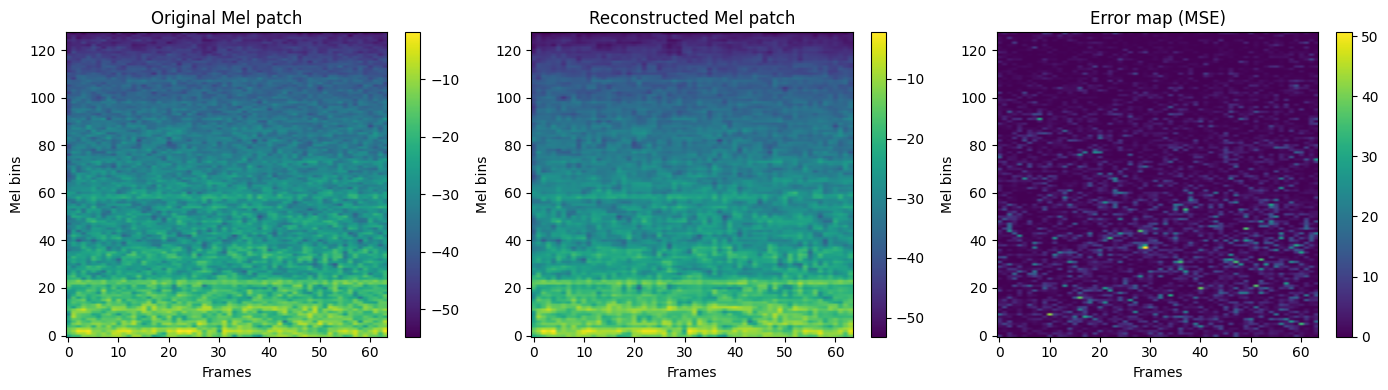

Worst-scoring file: anomaly_id_02_00000032.wav


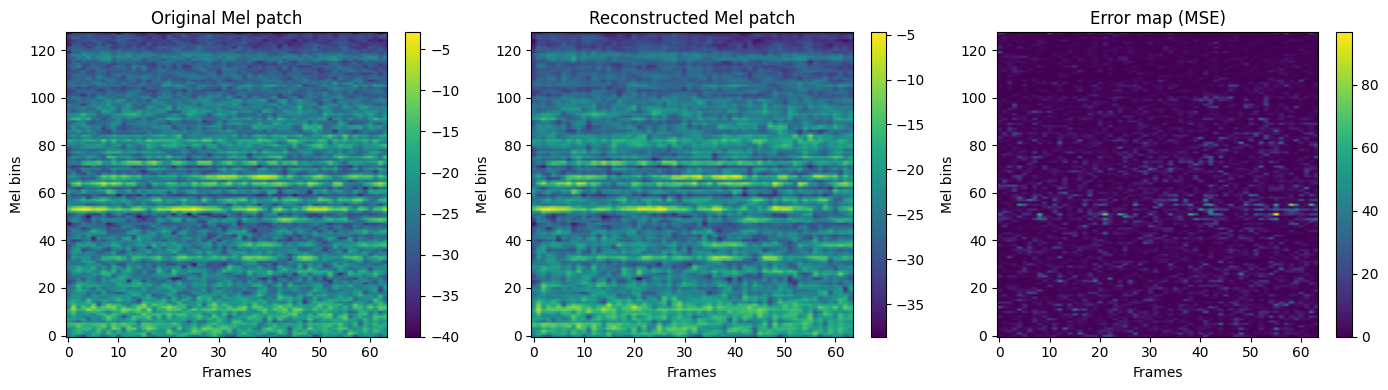

In [10]:
def visualize_triptych(wav_path: Path, model: nn.Module, mean: float, std: float, patch_t=PATCH_T):
    """
    Show original Mel, reconstructed Mel, and error map for the first patch of a file.
    This helps you see what the model learns and where it fails.
    """
    model.eval()

    # 1) Compute Mel and patches
    mel = wav_to_logmel(wav_path)                 # [M,T]
    patches = extract_patches(mel, win_t=patch_t) # [N,1,M,T]
    if len(patches) == 0:
        print("No patches found.")
        return
    x = patches[0:1]                              # pick first patch [1,1,M,T]

    # 2) Normalize with training stats
    x_norm = (x - mean) / std

    # 3) Run through model
    with torch.no_grad():
        x_t = torch.from_numpy(x_norm).to(DEVICE, dtype=torch.float32)
        y_t = model(x_t)
        y = y_t.detach().cpu().numpy()            # [1,1,M,T]

    # 4) De-normalize back to Mel scale
    x_rec = y * std + mean                        # [1,1,M,T]
    x_orig = x                                    # [1,1,M,T]
    err = (x_rec - x_orig) ** 2                   # pixel-wise MSE, same shape

    # 5) Plot three panels
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    im0 = axs[0].imshow(x_orig[0,0], aspect="auto", origin="lower")
    axs[0].set_title("Original Mel patch")
    fig.colorbar(im0, ax=axs[0], fraction=0.046)

    im1 = axs[1].imshow(x_rec[0,0], aspect="auto", origin="lower")
    axs[1].set_title("Reconstructed Mel patch")
    fig.colorbar(im1, ax=axs[1], fraction=0.046)

    im2 = axs[2].imshow(err[0,0], aspect="auto", origin="lower")
    axs[2].set_title("Error map (MSE)")
    fig.colorbar(im2, ax=axs[2], fraction=0.046)

    for ax in axs: ax.set_xlabel("Frames"); ax.set_ylabel("Mel bins")
    plt.tight_layout()
    plt.show()

# Example: show a normal-looking test file and a high-score file
# normal-ish
visualize_triptych(test_paths[0], model, ds_train_full.mean, ds_train_full.std, patch_t=PATCH_T)

# highest-score file
scores_df = pd.DataFrame({"path": [str(p) for p in test_paths], "score": file_scores})
worst_path = Path(scores_df.sort_values("score", ascending=False).iloc[0]["path"])
print("Worst-scoring file:", worst_path.name)
visualize_triptych(worst_path, model, ds_train_full.mean, ds_train_full.std, patch_t=PATCH_T)

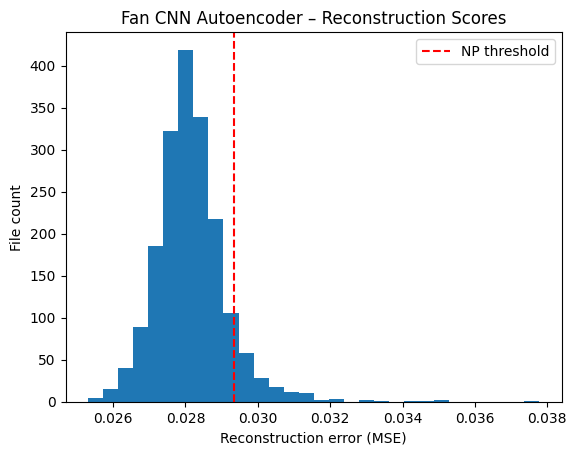

In [11]:
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv("../outputs/fan_cnn_scores.csv")
plt.hist(df["score"], bins=30)
plt.axvline(df["np_threshold_patch"].iloc[0], color="r", ls="--", label="NP threshold")
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("File count")
plt.title("Fan CNN Autoencoder – Reconstruction Scores")
plt.legend(); plt.show()